<a href="https://colab.research.google.com/github/KauaHenSilva/python_facial_detection/blob/main/face_descriptor_detection/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import dlib
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Setup

In [2]:

import requests
import os
import zipfile
import shutil

url1 = "https://raw.githubusercontent.com/GuoQuanhao/68_points/master/shape_predictor_68_face_landmarks.dat"
url2 = "https://raw.githubusercontent.com/ageitgey/face_recognition_models/master/face_recognition_models/models/dlib_face_recognition_resnet_model_v1.dat"

request1 = requests.get(url1)
request2 = requests.get(url2)

with open('shape_predictor_68_face_landmarks.dat', 'wb') as f:
    f.write(request1.content)

with open('dlib_face_recognition_resnet_model_v1.dat', 'wb') as f:
    f.write(request2.content)


def download_large_file_from_google_drive(file_id, destination):
    base_url = "https://drive.google.com/uc?export=download"

    with requests.Session() as session:
        response = session.get(base_url, params={'id': file_id}, stream=True)
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                confirm_token = value
                break
        else:
            confirm_token = None

        if confirm_token:
            params = {'id': file_id, 'confirm': confirm_token}
            response = session.get(base_url, params=params, stream=True)

        # Escrever o conteúdo do arquivo no destino
        with open(destination, 'wb') as f:
            for chunk in response.iter_content(32768):
                f.write(chunk)

download_large_file_from_google_drive('1DjGeC4tbRc3IBb8j2jJPGznBPUUSFVAz', 'people2.jpg')
download_large_file_from_google_drive('1l2wyk0--oFj_agtV2MuTPkkvfGZatTnN', 'yalefaces.rar')

with zipfile.ZipFile('yalefaces.rar', 'r') as zip_ref:
    zip_ref.extractall('yalefaces_temp')

if not os.path.exists('yalefaces'):
    shutil.move('yalefaces_temp/yalefaces', 'yalefaces')

shutil.rmtree('yalefaces_temp')
os.remove('yalefaces.rar')

In [3]:
face_detec = dlib.get_frontal_face_detector()
point_detec = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
descpritor_face_extact = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")

In [4]:
index = {}
idx = 0
faces_descrytors = None

images = []

paths = [os.path.join('yalefaces/train', f) for f in os.listdir('yalefaces/train')]
for path in paths:
  image = Image.open(path).convert('RGB')
  image_np = np.array(image, 'uint8')

  detecs = face_detec(image_np, 1)
  for face in detecs:

    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image_np, (l, t), (r, b), (0, 255, 0), 2)

    pontos = point_detec(image_np, face)
    for ponto in pontos.parts():
      cv2.circle(image_np, (ponto.x, ponto.y), 2, (0, 0, 255), 2)

    descritor_facial = descpritor_face_extact.compute_face_descriptor(image_np, pontos)
    descritor_facial = [df for df in descritor_facial]
    descritor_facial = np.array(descritor_facial, dtype=np.float64)
    descritor_facial = descritor_facial[np.newaxis, :]

    if faces_descrytors is None:
      faces_descrytors = descritor_facial
    else:
      faces_descrytors = np.concatenate((faces_descrytors, descritor_facial), axis=0)

  index[idx] = path
  idx += 1

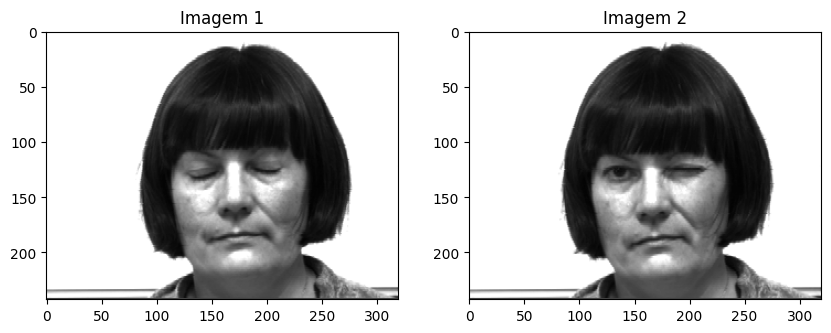

In [7]:
removed_idx = 4
new_index = {key: value for key, value in index.items() if key != removed_idx}
new_faces_descriptors = np.delete(faces_descrytors, removed_idx, axis=0)

target_descriptor = faces_descrytors[removed_idx]
imgId = np.argmin(np.linalg.norm(new_faces_descriptors - target_descriptor, axis=1))

# Ajustar imgId para refletir o índice correto no dicionário original
adjusted_imgId = list(new_index.keys())[imgId]

# Carregar as imagens correspondentes
image1 = Image.open(index[removed_idx]).convert('RGB')
image2 = Image.open(index[adjusted_imgId]).convert('RGB')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title('Imagem 1')
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title('Imagem 2')
plt.show()
